## Import packages and preprocess movie dataset

In [1]:
#%tensorflow_version 1.x

!pip install --upgrade tensorflow
!pip install -U Keras
!wget http://www.cs.cornell.edu/people/pabo/movie-review-data/review_polarity.tar.gz
!tar xzf review_polarity.tar.gz

Requirement already up-to-date: tensorflow in /usr/local/lib/python3.6/dist-packages (2.4.1)
Requirement already up-to-date: Keras in /usr/local/lib/python3.6/dist-packages (2.4.3)
--2021-02-15 10:33:42--  http://www.cs.cornell.edu/people/pabo/movie-review-data/review_polarity.tar.gz
Resolving www.cs.cornell.edu (www.cs.cornell.edu)... 132.236.207.36
Connecting to www.cs.cornell.edu (www.cs.cornell.edu)|132.236.207.36|:80... connected.
HTTP request sent, awaiting response... 200 OK
Length: 3127238 (3.0M) [application/x-gzip]
Saving to: ‘review_polarity.tar.gz.5’

review_polarity.tar 100%[===================>]   2.98M  1.93MB/s    in 1.5s    

2021-02-15 10:33:44 (1.93 MB/s) - ‘review_polarity.tar.gz.5’ saved [3127238/3127238]



# Load data





In [2]:
import re
import nltk
from pprint import pprint
from nltk.corpus import stopwords
from sklearn.utils import resample
import pandas as pd
import numpy as np
import tensorflow as tf
from keras.layers import BatchNormalization
from nltk.stem import WordNetLemmatizer
from sklearn.datasets import load_files
from sklearn.model_selection import train_test_split 
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.dummy import DummyClassifier
from sklearn.metrics import f1_score, confusion_matrix, classification_report, accuracy_score
from keras.utils.np_utils import to_categorical
import warnings
import sklearn.exceptions
warnings.filterwarnings("ignore", category=sklearn.exceptions.UndefinedMetricWarning)
warnings.simplefilter(action='ignore', category=FutureWarning)
from sklearn.metrics import roc_auc_score
from sklearn.metrics import roc_curve
from sklearn.metrics import classification_report
from sklearn.metrics import precision_score , recall_score
from keras.models import Model
from keras.models import Sequential
from keras.callbacks import ModelCheckpoint, EarlyStopping
from keras.layers import Input, Dense, Dropout, add
from keras.optimizers import Adam , SGD
from keras import optimizers
from keras import backend as K 
from keras.models import Sequential
from keras.layers.core import Dense, Dropout, Activation
from keras.datasets import mnist
from keras.utils import np_utils
from keras.callbacks import ModelCheckpoint
from sklearn.utils import resample
import numpy as np
from numpy.random import seed
import scipy
seed(1)

movies = load_files("txt_sentoken", encoding="utf-8")
Reviews, Labels = movies.data, movies.target
Reviews = np.asarray(Reviews)
nltk.download('wordnet')
nltk.download('stopwords')

[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


True

# Preprocessing data

In [3]:
stemmer = WordNetLemmatizer()
docs = []
for sen in range(0, len(Reviews)): 
  document = re.sub('\s+[\\n\\r]+', '', Reviews[sen])
  document = re.sub('\W', ' ', document)
  document = re.sub('\s+[a-zA-Z]\s+', ' ', document)
  document = document.lower()
  document = document.split()
  document = [stemmer.lemmatize(word) for word in document]
  document = ' '.join(document)
  docs.append(document)
print(len(docs))

2000


Split dataset into Train, Test and Validation

In [4]:
Reviews_train, Reviews_test, Labels_train, Labels_test = train_test_split(docs, Labels, test_size=0.3, random_state=1)
Reviews_val, Reviews_test, Labels_val, Labels_test = train_test_split(Reviews_test, Labels_test, test_size=0.333, random_state=1)

Print the length of the datasets to see how they have been splited

In [5]:
print("Train Data =",len(Reviews_train),len(Labels_train))
print("Test Data =",len(Reviews_test),len(Labels_test))
print("Validation Data =",len(Reviews_val),len(Labels_val))

Train Data = 1400 1400
Test Data = 200 200
Validation Data = 400 400


# Feature extraction (Tf*IDF n-gram features)

In [6]:
vectorizer = TfidfVectorizer(ngram_range=(1, 2), max_features=2000,sublinear_tf=True, stop_words=stopwords.words('english'))
Reviews_train_tfidf = vectorizer.fit_transform(Reviews_train)
Reviews_test_tfidf = vectorizer.transform(Reviews_test)
Reviews_val_tfidf = vectorizer.transform(Reviews_val)

# Models

## Baseline

In [7]:
base = DummyClassifier(strategy='most_frequent')
base.fit(Reviews_train_tfidf, Labels_train)

predictions = base.predict(Reviews_train_tfidf)
predictions_val = base.predict(Reviews_val_tfidf)
predictions_test = base.predict(Reviews_test_tfidf)

print('--------------Train set------------------------------------')
print(classification_report(Labels_train,predictions,digits=5))
print('--------------Validation set-------------------------------')
print(classification_report(Labels_val,predictions_val,digits=5))
print('--------------Test set-------------------------------------')
print(classification_report(Labels_test,predictions_test,digits=5))

--------------Train set------------------------------------
              precision    recall  f1-score   support

           0    0.00000   0.00000   0.00000       692
           1    0.50571   1.00000   0.67173       708

    accuracy                        0.50571      1400
   macro avg    0.25286   0.50000   0.33586      1400
weighted avg    0.25575   0.50571   0.33970      1400

--------------Validation set-------------------------------
              precision    recall  f1-score   support

           0    0.00000   0.00000   0.00000       209
           1    0.47750   1.00000   0.64636       191

    accuracy                        0.47750       400
   macro avg    0.23875   0.50000   0.32318       400
weighted avg    0.22801   0.47750   0.30864       400

--------------Test set-------------------------------------
              precision    recall  f1-score   support

           0    0.00000   0.00000   0.00000        99
           1    0.50500   1.00000   0.67110       101

  

## Logistic Regression: second baseline 

In [8]:
clf = LogisticRegression(solver="liblinear",C=0.9)
clf.fit(Reviews_train_tfidf, Labels_train)

predictions = clf.predict(Reviews_train_tfidf)
predictions_val = clf.predict(Reviews_val_tfidf)
predictions_test = clf.predict(Reviews_test_tfidf)

print('--------------Train set------------------------------------')
print(classification_report(Labels_train,predictions,digits=4))
print('--------------Validation set-------------------------------')
print(classification_report(Labels_val,predictions_val,digits=4))
print('--------------Test set-------------------------------------')
print(classification_report(Labels_test,predictions_test,digits=4))

--------------Train set------------------------------------
              precision    recall  f1-score   support

           0     0.9591    0.9480    0.9535       692
           1     0.9497    0.9605    0.9551       708

    accuracy                         0.9543      1400
   macro avg     0.9544    0.9542    0.9543      1400
weighted avg     0.9543    0.9543    0.9543      1400

--------------Validation set-------------------------------
              precision    recall  f1-score   support

           0     0.8829    0.8660    0.8744       209
           1     0.8564    0.8743    0.8653       191

    accuracy                         0.8700       400
   macro avg     0.8697    0.8702    0.8698       400
weighted avg     0.8703    0.8700    0.8700       400

--------------Test set-------------------------------------
              precision    recall  f1-score   support

           0     0.8854    0.8586    0.8718        99
           1     0.8654    0.8911    0.8780       101

  

## MLP Sequential model: a linear stack of layers



In [9]:
n_classes = 1
model = Sequential()
model.add(Dense(256, input_shape=(Reviews_train_tfidf.shape[1],) , activation='relu'))
model.add(Dropout(0.5))
model.add(Dense(n_classes, activation='sigmoid'))

Plotting the MLP model

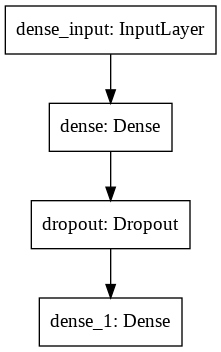

In [10]:
%matplotlib notebook
from keras.utils import plot_model

plot_model(model, to_file='model.png')

from IPython.display import Image 
Image('model.png')

## Compile

In [11]:
sgd = SGD(lr=0.01, decay=1e-6, momentum=0.9, nesterov=True)
adam = Adam(lr=0.0001, decay=1e-6)

model.compile(loss='binary_crossentropy',
                  optimizer=sgd,
                  metrics=["accuracy"])
print(model.summary())

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense (Dense)                (None, 256)               512256    
_________________________________________________________________
dropout (Dropout)            (None, 256)               0         
_________________________________________________________________
dense_1 (Dense)              (None, 1)                 257       
Total params: 512,513
Trainable params: 512,513
Non-trainable params: 0
_________________________________________________________________
None


## Fit

In [12]:
def convert_sparse_matrix_to_sparse_tensor(X):
    coo = X.tocoo()
    indices = np.mat([coo.row, coo.col]).transpose()
    return tf.SparseTensor(indices, coo.data, coo.shape)

In [13]:
checkpoint = ModelCheckpoint('keras_tf_idf_model.hdf5', monitor='val_f1', verbose=1, save_best_only=True, mode='max')
early_stopping = EarlyStopping(monitor='val_loss', patience=3, restore_best_weights=True)

Reviews_val_tfidf_temp = convert_sparse_matrix_to_sparse_tensor(Reviews_val_tfidf)
Reviews_train_tfidf_temp = convert_sparse_matrix_to_sparse_tensor(Reviews_train_tfidf)
Reviews_test_tfidf_temp = convert_sparse_matrix_to_sparse_tensor(Reviews_test_tfidf)

Reviews_val_tfidf1=tf.sparse.reorder(Reviews_val_tfidf_temp)
Reviews_train_tfidf1=tf.sparse.reorder(Reviews_train_tfidf_temp)
Reviews_test_tfidf1=tf.sparse.reorder(Reviews_test_tfidf_temp)

history = model.fit(Reviews_train_tfidf1, Labels_train,
              batch_size=64,
              validation_data=(Reviews_val_tfidf1, Labels_val),
              epochs=50,
              verbose=2,
              callbacks=[checkpoint, early_stopping]
              )

print("Evaluating... ")
print('Training data:', flush=True)
loss, acc = model.evaluate(Reviews_train_tfidf1, Labels_train, verbose=1)
print("  Train: loss %.3f - acc %.3f" % (loss, acc))
print('Cross-validation data:', flush=True)
loss, acc = model.evaluate(Reviews_val_tfidf1, Labels_val, verbose=1)
print("  Cross-val: loss %.3f - acc %.3f" % (loss, acc))
print('Test data:', flush=True)
loss, acc = model.evaluate(Reviews_test_tfidf1, Labels_test, verbose=1)
print("  Test: loss %.3f - acc %.3f" % (loss, acc))

Epoch 1/50
22/22 - 1s - loss: 0.6929 - accuracy: 0.4943 - val_loss: 0.6928 - val_accuracy: 0.5325
Epoch 2/50
22/22 - 0s - loss: 0.6920 - accuracy: 0.5121 - val_loss: 0.6920 - val_accuracy: 0.5375
Epoch 3/50
22/22 - 0s - loss: 0.6906 - accuracy: 0.5443 - val_loss: 0.6913 - val_accuracy: 0.5350
Epoch 4/50
22/22 - 0s - loss: 0.6891 - accuracy: 0.5700 - val_loss: 0.6899 - val_accuracy: 0.5950
Epoch 5/50
22/22 - 0s - loss: 0.6878 - accuracy: 0.6071 - val_loss: 0.6891 - val_accuracy: 0.5825
Epoch 6/50
22/22 - 0s - loss: 0.6863 - accuracy: 0.6293 - val_loss: 0.6876 - val_accuracy: 0.6275
Epoch 7/50
22/22 - 0s - loss: 0.6856 - accuracy: 0.6043 - val_loss: 0.6871 - val_accuracy: 0.5775
Epoch 8/50
22/22 - 0s - loss: 0.6842 - accuracy: 0.6386 - val_loss: 0.6856 - val_accuracy: 0.6400
Epoch 9/50
22/22 - 0s - loss: 0.6828 - accuracy: 0.6364 - val_loss: 0.6842 - val_accuracy: 0.6625
Epoch 10/50
22/22 - 0s - loss: 0.6797 - accuracy: 0.6743 - val_loss: 0.6832 - val_accuracy: 0.6300
Epoch 11/50
22/22 -

## Visualize Model Training History 

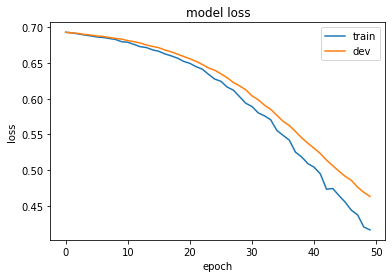

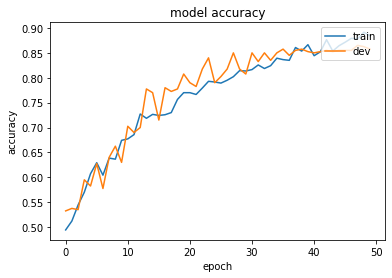

In [14]:
%matplotlib inline
import matplotlib.pyplot as plt
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'dev'], loc='upper right')
plt.show()

plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'dev'], loc='upper right')
plt.show()

# Evaluate performance of the MLP model

## Precision Recall & F1 Score of the MLP model

In [15]:
def scores(test_tfidf,y_label):
 predictions = model.predict_classes(test_tfidf)
 f1_scores = f1_score(y_label,predictions,average='macro')
 print(" f1-score: %.2f%%"%(f1_scores*100))
 precision_scores = precision_score(y_label,predictions,average='macro')
 print(" Precision-score: %.2f%%"%(precision_scores*100))
 recall_scores = recall_score(y_label,predictions,average='macro')
 print(" Recall-score: %.2f%%"%(recall_scores*100))

In [16]:
print('--------------Train set------------------------------------')
scores(Reviews_train_tfidf1,Labels_train)
print('--------------Test set------------------------------------')
scores(Reviews_test_tfidf1,Labels_test)
print('--------------Val set------------------------------------')
scores(Reviews_val_tfidf1,Labels_val)


--------------Train set------------------------------------
 f1-score: 91.78%
 Precision-score: 91.83%
 Recall-score: 91.77%
--------------Test set------------------------------------
 f1-score: 85.49%
 Precision-score: 85.54%
 Recall-score: 85.48%
--------------Val set------------------------------------
 f1-score: 85.73%
 Precision-score: 85.71%
 Recall-score: 85.75%


/usr/local/lib/python3.6/dist-packages/tensorflow/python/keras/engine/sequential.py:450: UserWarning: `model.predict_classes()` is deprecated and will be removed after 2021-01-01. Please use instead:* `np.argmax(model.predict(x), axis=-1)`,   if your model does multi-class classification   (e.g. if it uses a `softmax` last-layer activation).* `(model.predict(x) > 0.5).astype("int32")`,   if your model does binary classification   (e.g. if it uses a `sigmoid` last-layer activation).
  warnings.warn('`model.predict_classes()` is deprecated and '


## Macro-averaged precision, recall, F1 scores 

In [17]:
predictions = model.predict_classes(Reviews_train_tfidf1)
predictions_val = model.predict_classes(Reviews_val_tfidf1)
predictions_test = model.predict_classes(Reviews_test_tfidf1)

print('--------------Train set------------------------------------')
print(classification_report(Labels_train,predictions.ravel(),digits=4))
print('--------------Validation set-------------------------------')
print(classification_report(Labels_val,predictions_val.ravel(),digits=4))
print('--------------Test set-------------------------------------')
print(classification_report(Labels_test,predictions_test.ravel(),digits=4))

--------------Train set------------------------------------
              precision    recall  f1-score   support

           0     0.9300    0.9017    0.9156       692
           1     0.9067    0.9336    0.9200       708

    accuracy                         0.9179      1400
   macro avg     0.9183    0.9177    0.9178      1400
weighted avg     0.9182    0.9179    0.9178      1400

--------------Validation set-------------------------------
              precision    recall  f1-score   support

           0     0.8689    0.8565    0.8627       209
           1     0.8454    0.8586    0.8519       191

    accuracy                         0.8575       400
   macro avg     0.8571    0.8575    0.8573       400
weighted avg     0.8577    0.8575    0.8575       400

--------------Test set-------------------------------------
              precision    recall  f1-score   support

           0     0.8646    0.8384    0.8513        99
           1     0.8462    0.8713    0.8585       101

  

/usr/local/lib/python3.6/dist-packages/tensorflow/python/keras/engine/sequential.py:450: UserWarning: `model.predict_classes()` is deprecated and will be removed after 2021-01-01. Please use instead:* `np.argmax(model.predict(x), axis=-1)`,   if your model does multi-class classification   (e.g. if it uses a `softmax` last-layer activation).* `(model.predict(x) > 0.5).astype("int32")`,   if your model does binary classification   (e.g. if it uses a `sigmoid` last-layer activation).
  warnings.warn('`model.predict_classes()` is deprecated and '


# BootStrap(Baseline Model vs MLP Model)

In [18]:
def BootStrap(test_set=Reviews_test_tfidf1,test_set1=Reviews_test_tfidf,y_test=Labels_test,b=30):

  predictions_mlp = model.predict_classes(test_set)
  predictions_base = base.predict(test_set)

  f1_score_mlp = f1_score(y_test,predictions_mlp,average='macro')
  f1_score_base = f1_score(y_test,predictions_base,average='macro')

  delta = f1_score_mlp-f1_score_base
  s=0
  for _ in range(b):

    X_test_sample, y_test_sample = resample(test_set1,y_test)

    X_test_sample = convert_sparse_matrix_to_sparse_tensor(X_test_sample)
    X_test_sample=tf.sparse.reorder(X_test_sample)

    predictions_mlp_sample = model.predict_classes(X_test_sample)
    predictions_base_sample = base.predict( X_test_sample)

    f1_score_mlp_sample = f1_score(y_test_sample,predictions_mlp_sample,average='macro')
    f1_score_base_sample = f1_score(y_test_sample,predictions_base_sample,average='macro')
    delta_star =f1_score_base_sample - f1_score_mlp_sample 
    if delta_star > 2*delta:
      s+=1

  return round(s/b,4)

In [19]:
pvalue=BootStrap()
print(pvalue)

/usr/local/lib/python3.6/dist-packages/tensorflow/python/keras/engine/sequential.py:450: UserWarning: `model.predict_classes()` is deprecated and will be removed after 2021-01-01. Please use instead:* `np.argmax(model.predict(x), axis=-1)`,   if your model does multi-class classification   (e.g. if it uses a `softmax` last-layer activation).* `(model.predict(x) > 0.5).astype("int32")`,   if your model does binary classification   (e.g. if it uses a `sigmoid` last-layer activation).
  warnings.warn('`model.predict_classes()` is deprecated and '


0.0


# BootStrap(Logistic Regression Model vs MLP Model)

In [20]:
def BootStrap1(test_set=Reviews_test_tfidf1,test_set1=Reviews_test_tfidf,y_test=Labels_test,b=30):

  predictions_log = clf.predict(test_set1)
  predictions_mlp = model.predict_classes(test_set)
  
  f1_score_log = f1_score(y_test,predictions_log,average='macro')
  f1_score_mlp = f1_score(y_test,predictions_mlp,average='macro')

  delta = f1_score_log-f1_score_mlp
  s=0
  for _ in range(b):
    X_test_sample, y_test_sample = resample(test_set1,y_test)

    X_test_sample1 = convert_sparse_matrix_to_sparse_tensor(X_test_sample)
    X_test_sample1 =tf.sparse.reorder(X_test_sample1)

    predictions_log_sample = clf.predict(X_test_sample)
    predictions_mlp_sample = model.predict_classes( X_test_sample1)

    f1_score_log_sample = f1_score(y_test_sample,predictions_log_sample,average='macro')
    f1_score_mlp_sample = f1_score(y_test_sample,predictions_mlp_sample,average='macro')

    delta_star =f1_score_log_sample - f1_score_mlp_sample 
    if delta_star > 2*delta:
      s+=1

  return round(s/b,4)
  

In [21]:
pvalue1=BootStrap1()
print(pvalue1)

/usr/local/lib/python3.6/dist-packages/tensorflow/python/keras/engine/sequential.py:450: UserWarning: `model.predict_classes()` is deprecated and will be removed after 2021-01-01. Please use instead:* `np.argmax(model.predict(x), axis=-1)`,   if your model does multi-class classification   (e.g. if it uses a `softmax` last-layer activation).* `(model.predict(x) > 0.5).astype("int32")`,   if your model does binary classification   (e.g. if it uses a `sigmoid` last-layer activation).
  warnings.warn('`model.predict_classes()` is deprecated and '


0.1


# ROC curves for Baseline & MLP model

In [22]:
def plot_roc_curve(fpr,tpr):
  plt.plot(fpr,tpr)
  plt.axis([0,1,0,1])
  plt.xlabel('False Positive Rate')
  plt.ylabel('True Positive Rate')
  plt.show()

AUC score for MLP: 0.930093


/usr/local/lib/python3.6/dist-packages/tensorflow/python/keras/engine/sequential.py:425: UserWarning: `model.predict_proba()` is deprecated and will be removed after 2021-01-01. Please use `model.predict()` instead.
  warnings.warn('`model.predict_proba()` is deprecated and '


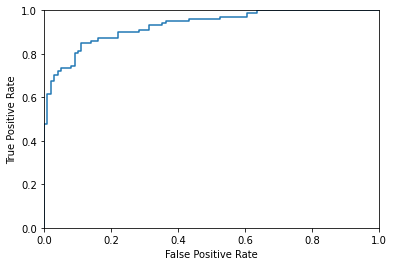

AUC score for Baseline: 0.500000


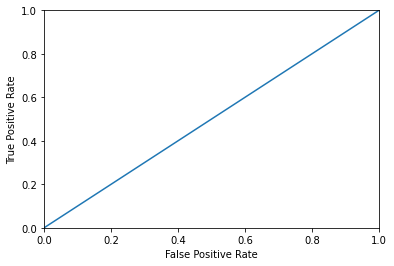

AUC score for Logistic: 0.874837


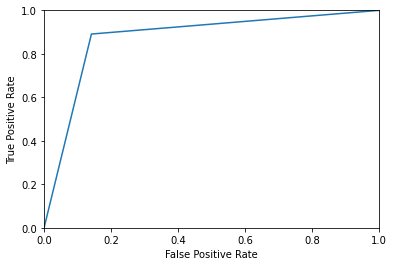

In [23]:
#------------For MLP Model------------
y_test_cat_prob=model.predict_proba(Reviews_test_tfidf1)
fpr , tpr , thresholds = roc_curve( Labels_test, y_test_cat_prob)
auc = roc_auc_score(Labels_test, y_test_cat_prob)
print('AUC score for MLP: %f' % auc)
plot_roc_curve(fpr,tpr) 
#----------For Baseline Model---------
predictions = base.predict(Reviews_test_tfidf1)
fpr , tpr , thresholds = roc_curve( Labels_test, predictions)
auc = roc_auc_score(Labels_test, predictions)
print('AUC score for Baseline: %f' % auc)
plot_roc_curve(fpr,tpr)

#----------For Logistic Regression--------
predictions = clf.predict(Reviews_test_tfidf)
fpr , tpr , thresholds = roc_curve( Labels_test, predictions)
auc = roc_auc_score(Labels_test, predictions)
print('AUC score for Logistic: %f' % auc)
plot_roc_curve(fpr,tpr)